In [1]:
import drift_algorithms as algo
import numpy as np 
import json
import emip_toolkit as EMTK
import pandas as pd
import correction
import tensorflow as tf
import prep_GB_img as prepgb
import matplotlib.pyplot as plt

## RS81

In [2]:
dir = "Golden_Set/"
folder_prefix = "R"
trial_prefix = "S"

In [3]:
model = tf.keras.models.load_model("saved_models/model_tl.h5")

input_x = 520
input_y = 299

# pick the optimal correction algorithm
good_algo = {
    0: "split",
    1: "merge",
    2: "warp",
    3: "cluster"
}

In [5]:
from pathlib import Path
import glob

attach_results = [[],[],[],[]]
chain_results = [[],[],[],[]]
cluster_results = [[],[],[],[]]
compare_results = [[],[],[],[]]
merge_results = [[],[],[],[]]
regress_results = [[],[],[],[]]
segment_results = [[],[],[],[]]
split_results = [[],[],[],[]]
stretch_results = [[],[],[],[]]
warp_results = [[],[],[],[]]
classifier_results = [[],[],[],[]]
classifier_predictions = [[],[],[],[]]

for f in range(4):
    folder = folder_prefix + str(f+1)
    file_path = dir + folder + "/" 
    image = folder + ".png"
    txt_file_name = folder + ".txt"

    aoi = EMTK.find_aoi(image, file_path, level="sub-line")
    aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, txt_file_name, aoi)
    line_ys = correction.find_lines_Y(aois_with_tokens)

    word_centers = correction.find_word_centers(aoi)
    word_centers = np.array(word_centers.copy(), dtype=int)

    duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
    duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)
    
    # number of json files in the folder
    n_jsons = len(glob.glob1(file_path,"*.json"))

    # safety check
    if n_jsons % 2 != 0:
        print("ERROR WITH FILES")
        exit()

    for t in range (n_jsons // 2):
        dirty = file_path + folder + "_" + trial_prefix + str(t+1) + ".json"
        with open(dirty) as d:
            dirty_dict = json.load(d)
        
        #dirty dataframe
        dirty_df = pd.DataFrame.from_dict(dirty_dict)
        #Transpose the dirty
        dirty_df = pd.DataFrame.transpose(dirty_df)
        #convert to numpy
        dirty_np = np.array(dirty_df)

        # clean, corrected data
        clean = file_path + folder + "_" + trial_prefix + str(t+1) + "_CORRECTED.json"
        with open(clean) as c:
            clean_dict = json.load(c)

        clean_fixs = clean_dict["fixations_data"]
        clean_df = pd.DataFrame.from_dict(clean_fixs)
        clean_df = pd.DataFrame.transpose(clean_df)
        clean_np = np.array(clean_df)
        
        #run the algorithms
        
        #attach
        np_array = np.array(dirty_np.copy())
        correction_p = algo.attach(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        attach_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)
        
        #chain
        np_array = np.array(dirty_np.copy())
        correction_p = algo.chain(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        chain_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)    
        
        #cluster
        np_array = np.array(dirty_np.copy())
        correction_p = algo.cluster(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        cluster_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)
        
        # compare
        np_array = np.array(dirty_np.copy())
        correction_p = algo.compare(np_array, duration_word_centers)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        compare_results[f].append(percentage)
        
        #merge
        np_array = np.array(dirty_np.copy())
        correction_p = algo.merge(np_array, line_ys, y_thresh = 50)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        merge_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)
        
        #regress
        np_array = np.array(dirty_np.copy())
        correction_p = algo.regress(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        regress_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)

        #segment
        np_array = np.array(dirty_np.copy())
        correction_p = algo.segment(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        segment_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)

        #split
        np_array = np.array(dirty_np.copy())
        correction_p = algo.split(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        split_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)
        
        #stretch
        np_array = np.array(dirty_np.copy())
        correction_p = algo.stretch(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, clean_np, correction_p)
        stretch_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)
        
        # warp
        np_array = np.array(dirty_np.copy(), dtype=int)
        durations = np.delete(np_array, 0, 1)
        durations = np.delete(durations, 0, 1)
        np_array = np.delete(np_array, 2, 1)
        warp_correction = algo.warp(np_array, word_centers)
        percentage, match_list = correction.correction_quality(aoi, clean_np, warp_correction)
        warp_results[f].append(percentage)
        #  correction.draw_correction(image_path+image, correction_p, match_list)

        # with classifier
        np_array = np.array(dirty_np.copy())
        predicted_error = correction.predict_error(
                    file_path + image, 
                    np_array, 
                    aois_with_tokens, 
                    input_x, 
                    input_y, 
                    model)
        if predicted_error == 4: # no error case - use regress
            this_correction = correction.apply_correction(
                "regress", 
                np_array, 
                line_ys, 
                duration_word_centers, 
                word_centers)
            percentage, match_list = correction.correction_quality (aoi, clean_np, this_correction)
        else:
            this_correction = correction.apply_correction(
                good_algo[predicted_error], 
                np_array, 
                line_ys, 
                duration_word_centers, 
                word_centers)
            percentage, match_list = correction.correction_quality (aoi, clean_np, this_correction)
        
        classifier_predictions[f].append(predicted_error)
        classifier_results[f].append(percentage)
                

In [6]:
import statistics

def mean_stats_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

mean_attach = mean_stats_group(attach_results)
mean_chain = mean_stats_group(chain_results)
mean_cluster = mean_stats_group(cluster_results)
mean_compare = mean_stats_group(compare_results)
mean_merge = mean_stats_group(merge_results)
mean_regress = mean_stats_group(regress_results)
mean_segment = mean_stats_group(segment_results)
mean_split = mean_stats_group(split_results)
mean_stretch = mean_stats_group(stretch_results)
mean_warp = mean_stats_group(warp_results)
mean_classifier = mean_stats_group(classifier_results)

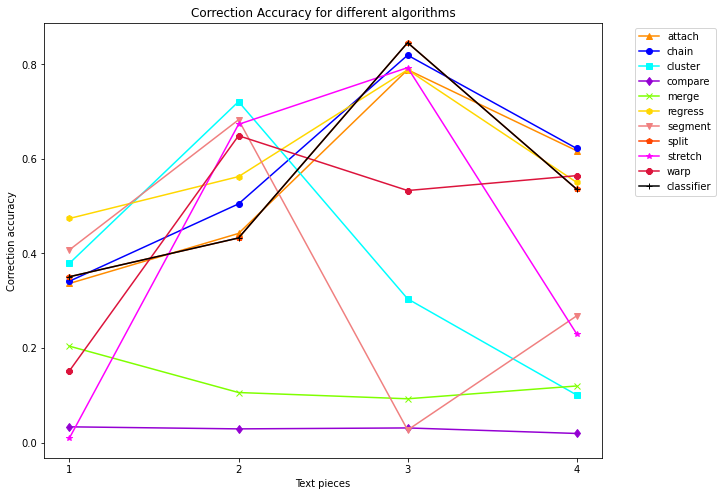

In [9]:
y = [i for i in range(1,5)]

plt.figure(figsize=(10,8))

plt.plot(y, attach_results[0], color='DarkOrange', marker='^')
plt.plot(y, chain_results[0], color='Blue', marker='o')
plt.plot(y, cluster_results[0], color='Aqua', marker='s')
plt.plot(y, compare_results[0], color='DarkViolet', marker='d')
plt.plot(y, merge_results[0], color='Chartreuse', marker='x')
plt.plot(y, regress_results[0], color='Gold', marker='h')
plt.plot(y, segment_results[0], color='lightcoral', marker='v')
plt.plot(y, split_results[0], color='orangered', marker='p')
plt.plot(y, stretch_results[0], color='magenta', marker='*')
plt.plot(y, warp_results[0], color='crimson', marker='8')
plt.plot(y, classifier_results[0], color='Black', marker='+')

plt.legend(
    ['attach', 'chain', 'cluster', 'compare', 'merge', 'regress', 'segment', 'split', 'stretch', 'warp', "classifier"], 
    bbox_to_anchor=(1.05, 1)
    )

plt.ylabel('Correction accuracy')
plt.xlabel('Text pieces')

x_ticks_labels = [1, 2, 3, 4]
plt.xticks(range(1, 5), x_ticks_labels)
plt.title("Correction Accuracy for different algorithms")
plt.show()

In [78]:
print("mean attach: ", mean_attach)
print("mean chain: ", mean_chain)
print("mean cluster: ", mean_cluster)
print("mean compare: ", mean_compare)
print("mean merge: ", mean_merge)
print("mean regress: ", mean_regress)
print("mean segment: ", mean_segment)
print("mean split: ", mean_split)
print("mean stretch: ", mean_stretch)
print("mean warp: ", mean_warp)
print("mean classifier: ", mean_classifier)

mean attach:  [0.546142929798084, 0.5893229729720194, 0.6042986600199016, 0.6945764742252105]
mean chain:  [0.5718581872714322, 0.5844057067506919, 0.6351346828039391, 0.6901905093129299]
mean cluster:  [0.4156596822590009, 0.33941135301795816, 0.6014415057968816, 0.811075044439292]
mean compare:  [0.0279993174206346, 0.03436231512783825, 0.022222193807529097, 0.03298168328309761]
mean merge:  [0.13042223451494633, 0.1804817163473598, 0.1508347100252152, 0.19979326068475153]
mean regress:  [0.593804784811367, 0.47143075413697166, 0.6494998729863217, 0.7648388592626942]
mean segment:  [0.3461623869686662, 0.09758314038172404, 0.0441970092967193, 0.11642128448875494]
mean split:  [0.5412758384009811, 0.5441718841963294, 0.6250325206162806, 0.6901905093129299]
mean stretch:  [0.42629305242081506, 0.5303042929130201, 0.655588829161204, 0.7913092201870314]
mean warp:  [0.4745825445808681, 0.37838539148905054, 0.4983660983159748, 0.6612953087564726]
mean classifier:  [0.5412758384009811, 0.5

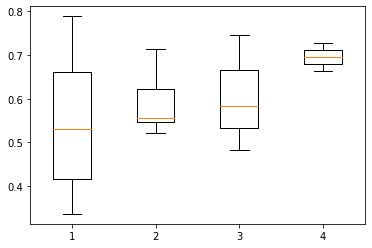

In [63]:
plt.boxplot(attach_results)
plt.show()